# Modeling using Regression

---

This notebook explores using Regression to predict the continuous variable of monthly **Oil (bbl/d) Total production** for a given Region in a given month, provided Nightfire-based Predictor Features (X Features). It will explore using Linear Regression, how and why it fails, as well as Tree-based Regression. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-using-Regression" data-toc-modified-id="Modeling-using-Regression-1">Modeling using Regression</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.2">Model Instantiation and Fit</a></span></li><li><span><a href="#Linear-Regression-All-Regions" data-toc-modified-id="Linear-Regression-All-Regions-1.3">Linear Regression All Regions</a></span></li><li><span><a href="#Linear-Regression-Individual-Regions" data-toc-modified-id="Linear-Regression-Individual-Regions-1.4">Linear Regression Individual Regions</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1.5">Random Forest</a></span></li><li><span><a href="#Extra-Trees" data-toc-modified-id="Extra-Trees-1.6">Extra Trees</a></span></li></ul></li><li><span><a href="#Interpreting" data-toc-modified-id="Interpreting-2">Interpreting</a></span></li></ul></div>

## Imports

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import datetime as dt
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


In [4]:
from tools.tools import read_json, get_current_time

In [5]:
plt.style.use('ggplot')

In [6]:
basin_colors_hex = {  # manually defined dictionary of EIA basin-level standardized colors 
    "Anadarko Region":    "#2BA2CF", 
    "Appalachia Region":  "#769F5D",
    "Bakken Region":      "#F6C432", 
    "Eagle Ford Region":  "#48366B", 
    "Haynesville Region": "#807B8F",
    "Niobrara Region":    "#9D3341",
    "Permian Region":     "#6F4B27",
}

In [7]:
config = read_json('../config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

In [8]:
df = pd.read_csv(f"{wd}/processing/basin_int_viirs_for_modeling.csv")

In [9]:
region_list = list(df['region'].unique())

In [10]:
df.head(3)

,year_month,region,latest_day_in_month,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,...,obs_day_cnt_avg_over_pct_month_completed,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed
0,2012-03-01,Anadarko Region,2012-03-31,13.041667,12.5,313,3,33,4.786164,4.291667,...,13.041667,12.5,313.0,3.0,33.0,1.728202e-10,1.656423e-10,4.147684e-09,3.975416e-11,4.372958e-10
1,2012-03-01,Appalachia Region,2012-03-31,31.071429,32.0,870,1,86,9.502222,8.966184,...,31.071429,32.0,870.0,1.0,86.0,1.616772e-10,1.665089e-10,4.526961e-09,5.203404e-12,4.474927e-10
2,2012-03-01,Bakken Region,2012-03-31,260.321429,249.0,7289,2,571,1.497039,1.500962,...,260.321429,249.0,7289.0,2.0,571.0,2.852491e-09,2.728436e-09,7.986976e-08,2.191515e-11,6.256775e-09


In [11]:
df.shape

(679, 84)

In [12]:
X = df.drop(columns=[
    'oil_bbl_d_total_production',
    'latest_day_in_month',
    'last_day_of_month',
    'first_day_of_month',
    'year_month',
])

X = pd.get_dummies(X)

y = df['oil_bbl_d_total_production']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=42,
)

In [13]:
X_train.shape

(509, 85)

In [14]:
for i in X.columns:
    print(i)  # check the columns putting into the model. 

obs_day_cnt_avg
obs_day_cnt_med
obs_day_cnt_sum
obs_day_cnt_min
obs_day_cnt_max
qf_fit_day_avg_avg
qf_fit_day_avg_med
qf_fit_day_avg_sum
qf_fit_day_avg_min
qf_fit_day_avg_max
qf_fit_day_med_avg
qf_fit_day_med_med
qf_fit_day_med_sum
qf_fit_day_med_min
qf_fit_day_med_max
qf_fit_day_sum_avg
qf_fit_day_sum_med
qf_fit_day_sum_sum
qf_fit_day_sum_min
qf_fit_day_sum_max
qf_fit_day_min_avg
qf_fit_day_min_med
qf_fit_day_min_sum
qf_fit_day_min_min
qf_fit_day_min_max
qf_fit_day_max_avg
qf_fit_day_max_med
qf_fit_day_max_sum
qf_fit_day_max_min
qf_fit_day_max_max
aland
obs_day_cnt_avg_per_squaremeters
obs_day_cnt_med_per_squaremeters
obs_day_cnt_sum_per_squaremeters
obs_day_cnt_min_per_squaremeters
obs_day_cnt_max_per_squaremeters
qf_fit_day_avg_avg_per_squaremeters
qf_fit_day_avg_med_per_squaremeters
qf_fit_day_avg_sum_per_squaremeters
qf_fit_day_avg_min_per_squaremeters
qf_fit_day_avg_max_per_squaremeters
qf_fit_day_med_avg_per_squaremeters
qf_fit_day_med_med_per_squaremeters
qf_fit_day_med_sum_per

In [15]:
X_test.shape

(170, 85)

## Model Instantiation and Fit

## Linear Regression All Regions

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train);

In [17]:
lr.score(X_train, y_train)

0.9284652722365356

In [18]:
lr.score(X_test, y_test)

-0.00011692365826543316

In [19]:
cross_val_score(lr, X, y, cv=10).mean()

-18.74414779918462

In [20]:
# Not good test score or cross val. Linear Regression does terribly. 
# Next try for individual regions. 

## Linear Regression Individual Regions

In [21]:
region_lr_dict = {}
for region in region_list:
    df_select = df[df['region'] == region]

    X_lr = df_select.drop(columns=[
        'oil_bbl_d_total_production',
        'latest_day_in_month',
        'last_day_of_month',
        'first_day_of_month',
        'year_month',
    ])

    X_lr = pd.get_dummies(X_lr)

    y_lr = df_select['oil_bbl_d_total_production']

    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
        X_lr, 
        y_lr, 
        random_state=42, 
        test_size=0.25,
    )

    lr = LinearRegression()
    lr.fit(X_train_lr, y_train_lr);

    train_score_lr = lr.score(X_train_lr, y_train_lr)

    test_score_lr = lr.score(X_test_lr, y_test_lr)
    
    cross_val_score_lr = cross_val_score(lr, X, y, cv=3).mean()
    
    region_lr_dict[region] = {
        "train_score_lr": train_score_lr,
        "test_score_lr": test_score_lr,
        "cross_val_score_lr": cross_val_score_lr,
        "model": lr,
    }
    
    print(
        region,
        "train_score_lr:", train_score_lr,
        "test_score_lr:", test_score_lr,
        "cross_val_score_lr:", cross_val_score_lr,
    ) 

Anadarko Region train_score_lr: 0.9363749376744117 test_score_lr: 0.6748751092816008 cross_val_score_lr: -5.682846080215898
Appalachia Region train_score_lr: 0.9191137204273848 test_score_lr: 0.6217166835603352 cross_val_score_lr: -5.682846080215898
Bakken Region train_score_lr: 0.8678112195206077 test_score_lr: 0.6986558857402126 cross_val_score_lr: -5.682846080215898
Eagle Ford Region train_score_lr: 0.7800431274381919 test_score_lr: -1.3345465237748777 cross_val_score_lr: -5.682846080215898
Haynesville Region train_score_lr: 0.9086195373228948 test_score_lr: 0.3727299081664469 cross_val_score_lr: -5.682846080215898
Niobrara Region train_score_lr: 0.9680902591669558 test_score_lr: -0.7017268421370304 cross_val_score_lr: -5.682846080215898
Permian Region train_score_lr: 0.9923873091090426 test_score_lr: 0.9682094672052732 cross_val_score_lr: -5.682846080215898


In [22]:
# These scores are not great either. Perhaps Tree-based. 

## Random Forest

In [23]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train);

In [24]:
rf.score(X_train, y_train)

0.9988654607828306

In [25]:
rf.score(X_test, y_test)

0.9944597268733544

In [26]:
cross_val_score(rf, X, y, cv=10).mean()

0.9374954835968072

In [27]:
important_features = pd.Series(data=rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features.head(20)

region_Permian Region                       0.436839
obs_day_cnt_avg                             0.123322
obs_day_cnt_med                             0.113758
latest_day_in_month_epochtime               0.044346
epochtime                                   0.042529
last_day_of_month_epochtime                 0.041288
first_day_of_month_epochtime                0.039116
obs_day_cnt_max                             0.026389
obs_day_cnt_med_over_pct_month_completed    0.017739
obs_day_cnt_avg_over_pct_month_completed    0.014869
qf_fit_day_avg_avg                          0.013269
obs_day_cnt_max_over_pct_month_completed    0.012233
year                                        0.011545
qf_fit_day_med_med                          0.010861
aland                                       0.010351
obs_day_cnt_sum_over_pct_month_completed    0.006600
qf_fit_day_med_avg                          0.005483
obs_day_cnt_sum                             0.004455
qf_fit_day_sum_med                          0.

## Extra Trees

In [28]:
et = ExtraTreesRegressor(random_state=42, n_estimators=500)
et.fit(X_train, y_train);

In [29]:
et.score(X_train, y_train)

1.0

In [30]:
et.score(X_test, y_test)

0.99829956120912

In [31]:
cross_val_score(et, X, y, cv=10).mean()

0.9697227210838758

In [32]:
important_features = pd.Series(data=et.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features.head(20)

region_Permian Region                                        0.558261
qf_fit_day_med_med                                           0.095868
qf_fit_day_med_avg                                           0.034875
obs_day_cnt_sum_per_squaremeters_over_pct_month_completed    0.034342
year                                                         0.029386
obs_day_cnt_sum_per_squaremeters                             0.029237
obs_day_cnt_avg                                              0.018299
region_Eagle Ford Region                                     0.017109
first_day_of_month_epochtime                                 0.016955
last_day_of_month_epochtime                                  0.016853
epochtime                                                    0.016359
latest_day_in_month_epochtime                                0.015812
obs_day_cnt_sum_over_pct_month_completed                     0.014760
obs_day_cnt_sum                                              0.014493
region_Appalachia Re

In [33]:
y_train.shape

(509,)

In [34]:
X

,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,qf_fit_day_avg_min,qf_fit_day_avg_max,...,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed,region_Anadarko Region,region_Appalachia Region,region_Bakken Region,region_Eagle Ford Region,region_Haynesville Region,region_Niobrara Region,region_Permian Region
0,13.041667,12.5,313,3,33,4.786164,4.291667,114.867926,0.000000,15.444444,...,4.147684e-09,3.975416e-11,4.372958e-10,1,0,0,0,0,0,0
1,31.071429,32.0,870,1,86,9.502222,8.966184,266.062205,0.000000,42.400000,...,4.526961e-09,5.203404e-12,4.474927e-10,0,1,0,0,0,0,0
2,260.321429,249.0,7289,2,571,1.497039,1.500962,41.917086,0.000000,4.189956,...,7.986976e-08,2.191515e-11,6.256775e-09,0,0,1,0,0,0,0
3,48.538462,30.0,1262,1,209,1.046799,0.374157,27.216779,0.000000,5.384615,...,1.954431e-08,1.548677e-11,3.236736e-09,0,0,0,1,0,0,0
4,4.476190,2.0,94,1,15,8.188339,0.000000,171.955128,0.000000,34.000000,...,1.926133e-09,2.049078e-11,3.073617e-10,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,213.875000,221.5,1711,51,371,6.692439,6.807222,53.539510,1.117647,10.956873,...,8.035032e-08,2.395013e-09,1.742254e-08,0,0,1,0,0,0,0
675,58.375000,31.0,467,1,172,1.953489,1.357558,15.627909,0.666667,4.500000,...,3.099567e-08,6.637189e-11,1.141597e-08,0,0,0,1,0,0,0
676,3.333333,1.0,10,1,8,3.000000,0.000000,9.000000,0.000000,9.000000,...,1.229447e-09,1.229447e-10,9.835573e-10,0,0,0,0,1,0,0
677,13.250000,12.5,106,4,28,5.852251,6.335714,46.818010,2.533333,8.500000,...,1.957081e-09,7.385213e-11,5.169649e-10,0,0,0,0,0,1,0


In [35]:
from sklearn.metrics import mean_squared_error

from math import sqrt

rmse = sqrt(mean_squared_error(y_test, et.predict(X_test)))

print(rmse)

272245.29239885614 / rmse

29999.194841718385


9.07508664266743

# Interpreting 

In [36]:
predicted = cross_val_predict(et, X, y, cv=10)

In [37]:
df['colors'] = df['region'].map(basin_colors_hex)  # adding custom colors column for plots

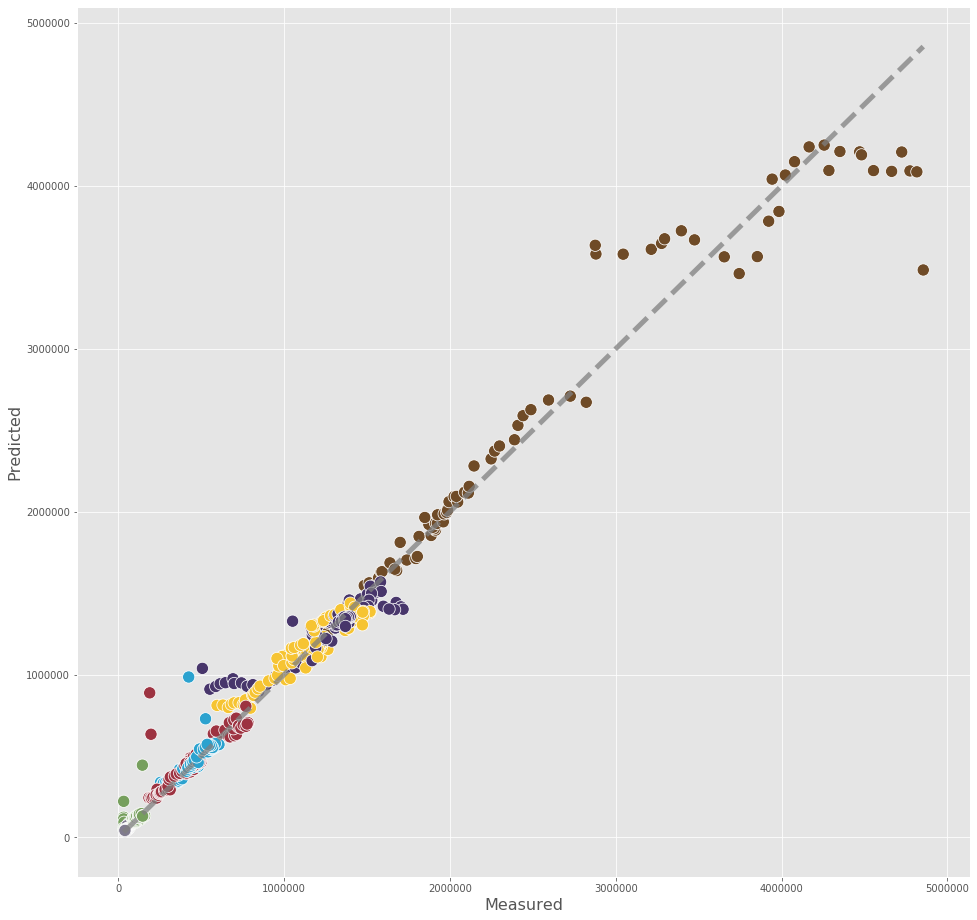

In [38]:
color_labels = df['region'].unique()
# print(color_labels)
# List of RGB triplets
rgb_values = sns.color_palette("Set2", 7)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

plt.figure(figsize=(16, 16))
# fig, ax = plt.subplots()

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=5, color='gray', alpha=0.75)

plt.scatter(y, predicted, c=df['colors'], edgecolors='white', s=150, alpha=1, linewidths=0.75)

plt.xlabel('Measured', fontsize=16)
plt.ylabel('Predicted', fontsize=16)

#plt.legend()
plt.show();

In [39]:
resids = y - predicted

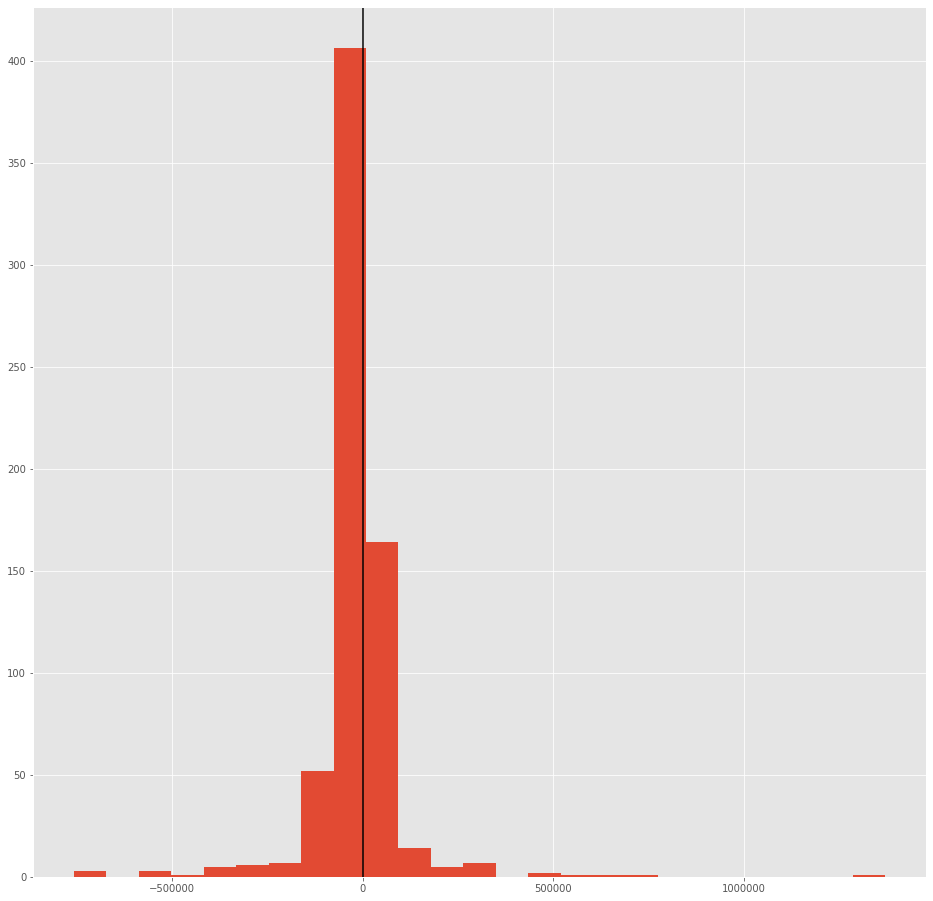

In [40]:
# Normality of residuals assumption
plt.figure(figsize=(16, 16))

plt.hist(resids, bins=25)
plt.axvline(0, color='black');

No handles with labels found to put in legend.


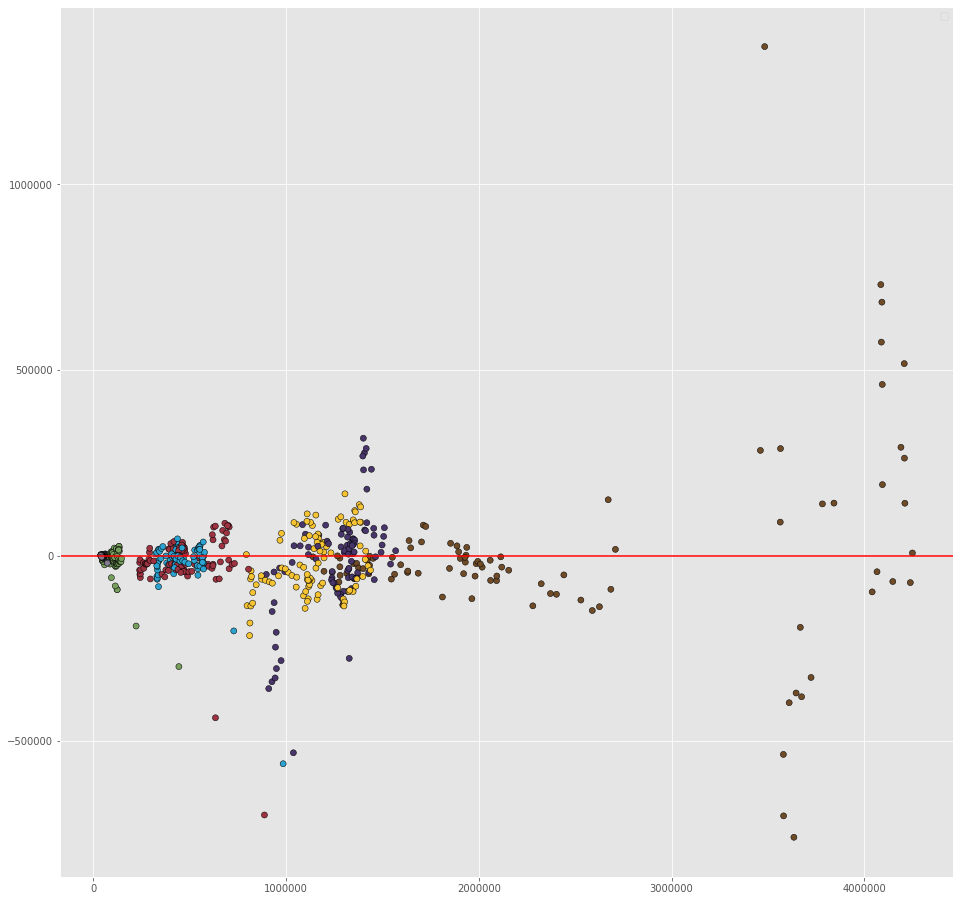

In [41]:
plt.figure(figsize=(16, 16))

plt.scatter(predicted, resids, edgecolors='black', c=df['colors'])

#legend_elements = [Patch(facecolor='orange', edgecolor='r', label='Color Patch')]
plt.legend()
plt.axhline(0, color='red');

In [42]:
df['predicted'] = predicted

In [43]:
#df.set_index('year_month', inplace=True)
df.sort_index(inplace=True)  # sort by datetime just to be safe

In [44]:
def eia_variable_plot(df_in, pred_var, actual_var, legend_loc=2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    region_list = list(df_in['region'].unique())
    region_list.sort()

    for region in region_list:
        df_pred = df_in[df_in['region'] == region][['region', pred_var, 'colors']]
        df_pred.plot(
            label=region,
            legend=True,
            ax=ax,
            color=df_pred['colors'],
            linewidth=2.5,
            linestyle='dashed',
        )
        
        df_actual = df_in[df_in['region'] == region][['region', actual_var, 'colors']]
        df_actual.plot(
            label=region,
            legend=True,
            ax=ax,
            color=df_actual['colors'],
            linewidth=2.5, 
        )

    fmt = '{x:,.0f}'
    # tick = mtick.StrMethodFormatter(fmt)
    # ax.yaxis.set_major_formatter(tick) 
    # ax.yaxis.set_minor_formatter(tick) 

    ax.set_ylabel(pred_var.replace('_', ' ').upper())
    ax.set_xlabel("MONTHLY EIA REPORTS")
    
    plt.legend(
        title='REGIONS', 
        loc=legend_loc, 
        shadow=True, 
        facecolor='white', 
        labels=[val for val in region_list for _ in (0, 1)],  #region_list,
    )
    plt.title(pred_var.replace('_', ' ').upper())
    
    plt.savefig(f'../images/eia_report_{pred_var}.png', dpi=300)
    plt.show();

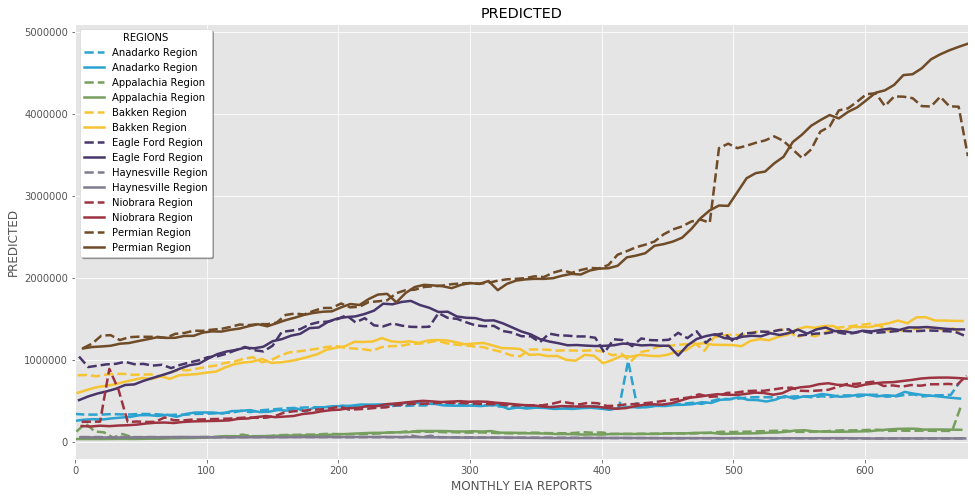

In [45]:
pred_var = 'predicted'
actual_var = 'oil_bbl_d_total_production'
eia_variable_plot(df, pred_var, actual_var)

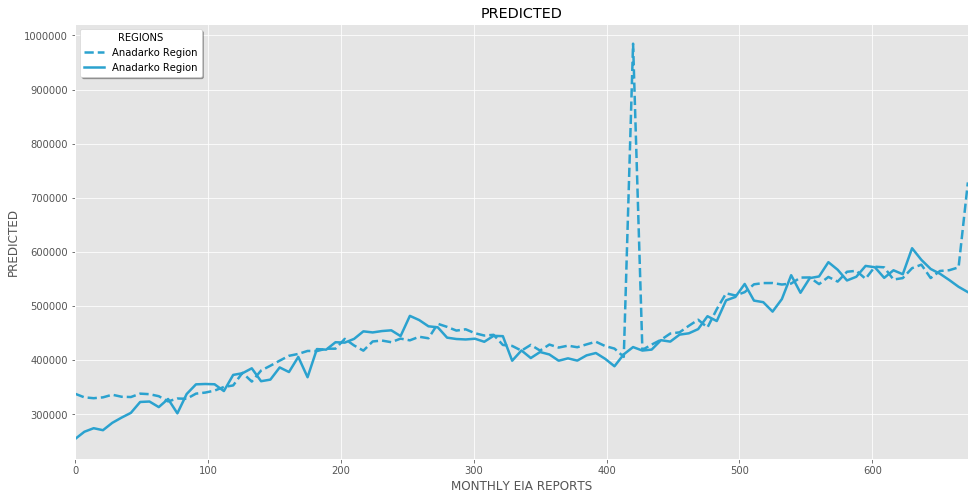

In [46]:
pred_var = 'predicted'
actual_var = 'oil_bbl_d_total_production'
eia_variable_plot(df[df['region'] == 'Anadarko Region'], pred_var, actual_var)

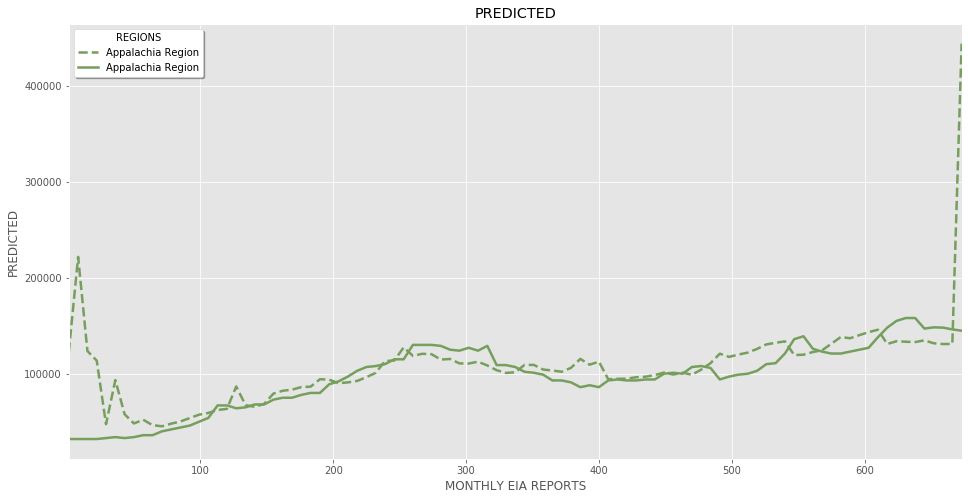

In [47]:
eia_variable_plot(df[df['region'] == 'Appalachia Region'], pred_var, actual_var)

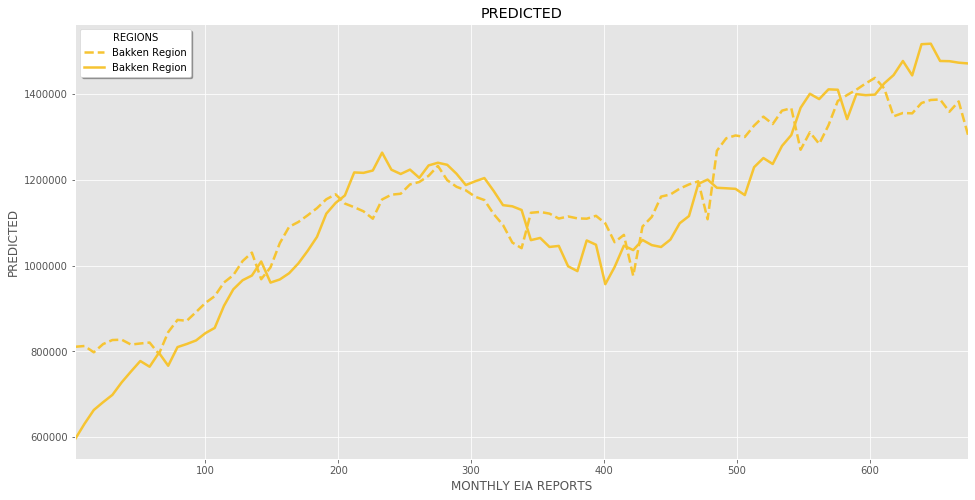

In [48]:
eia_variable_plot(df[df['region'] == "Bakken Region"], pred_var, actual_var)

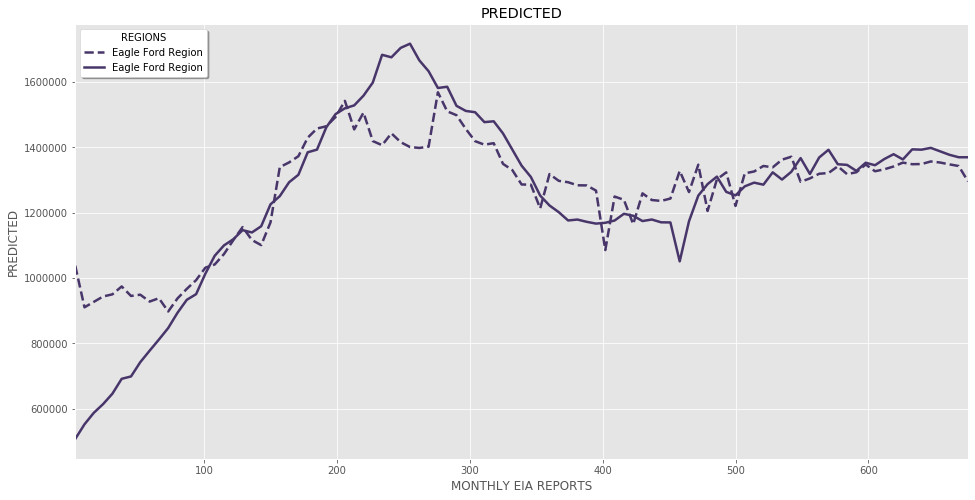

In [49]:
eia_variable_plot(df[df['region'] == "Eagle Ford Region"], pred_var, actual_var)

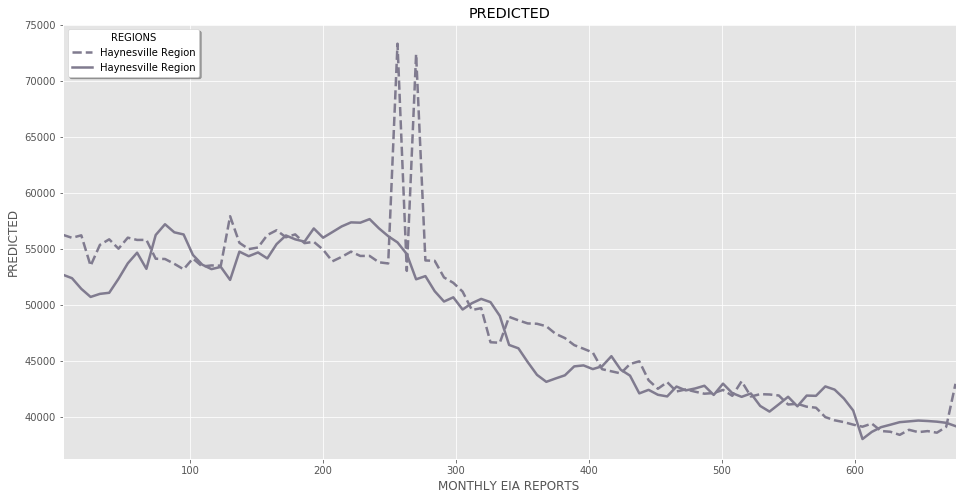

In [50]:
eia_variable_plot(df[df['region'] == "Haynesville Region"], pred_var, actual_var)


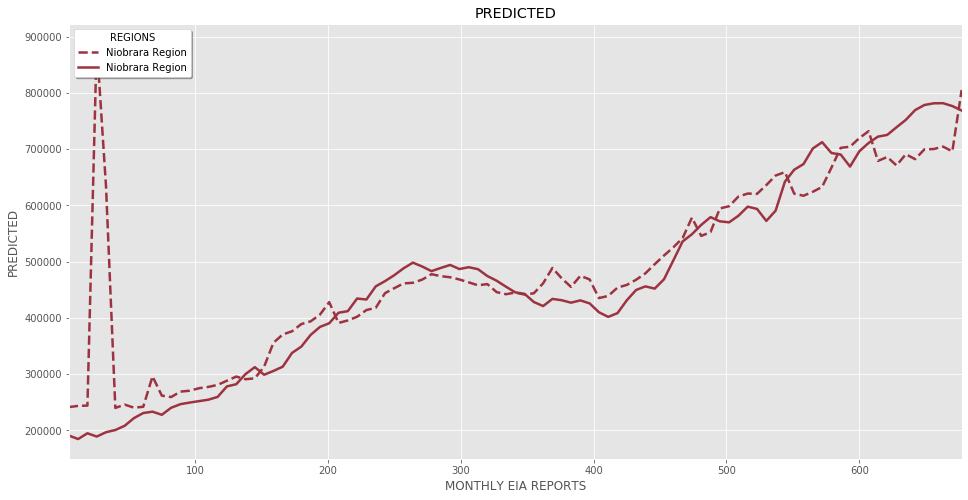

In [51]:
eia_variable_plot(df[df['region'] == "Niobrara Region"], pred_var, actual_var)


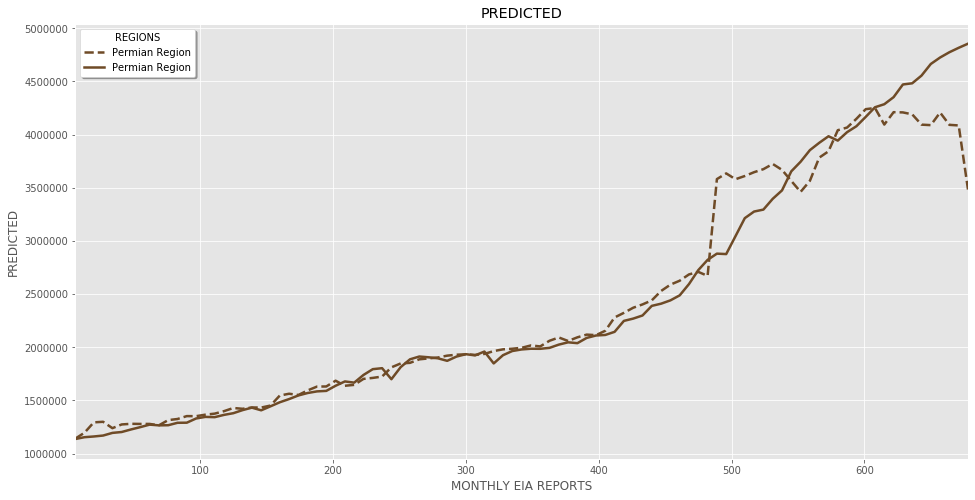

In [52]:
eia_variable_plot(df[df['region'] == "Permian Region"], pred_var, actual_var)

In [53]:

#eia_variable_plot(df, var)

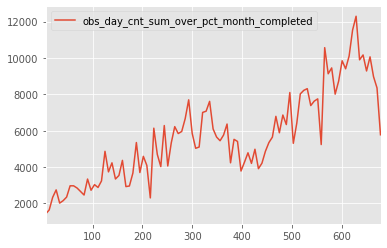

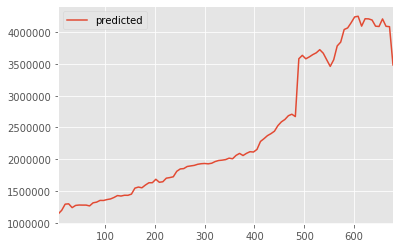

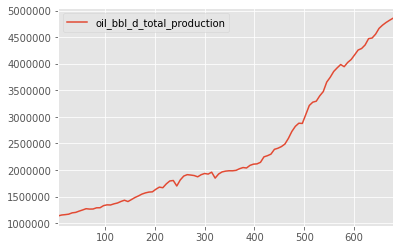

In [54]:
plt.figsize=(20, 10)

df[df['region'] == 'Permian Region'][['obs_day_cnt_sum_over_pct_month_completed']].plot()
df[df['region'] == 'Permian Region'][['predicted']].plot()
df[df['region'] == 'Permian Region'][['oil_bbl_d_total_production']].plot()

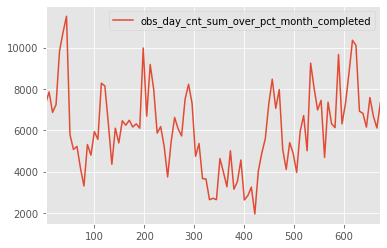

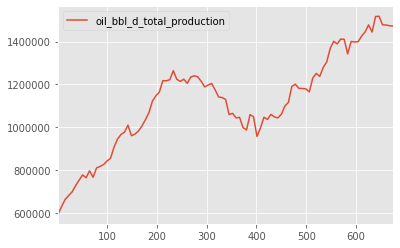

In [55]:
plt.figsize=(20, 10)

df[df['region'] == 'Bakken Region'][['obs_day_cnt_sum_over_pct_month_completed']].plot()
#df[df['region'] == 'Bakken Region'][['predicted']].plot()
df[df['region'] == 'Bakken Region'][['oil_bbl_d_total_production']].plot()

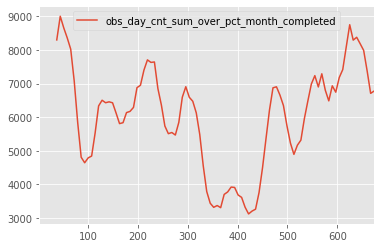

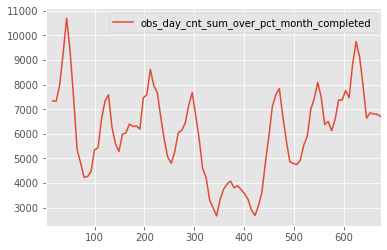

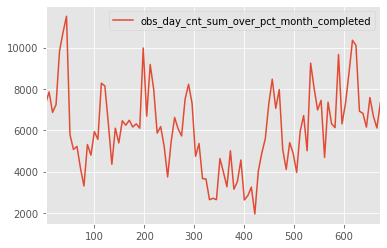

In [56]:
df[df['region'] == 'Bakken Region'][['obs_day_cnt_sum_over_pct_month_completed']].rolling(6).mean().plot()
df[df['region'] == 'Bakken Region'][['obs_day_cnt_sum_over_pct_month_completed']].rolling(3).mean().plot()

df[df['region'] == 'Bakken Region'][['obs_day_cnt_sum_over_pct_month_completed']].plot()

In [ ]:
# Next Notebook

[Modeling using Regression](https://git.generalassemb.ly/danielmartinsheehan/capstone/blob/master/notebooks/05_modeling.ipynb)